In [2]:
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

In [3]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

In [4]:
py_data = loadmat('data/py_odes.mat')

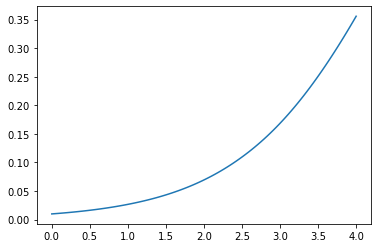

In [31]:
from scipy.integrate import solve_ivp

def f(t, y):
    return (y - y**2)
t = np.linspace(0, 4, 100)

res = solve_ivp(f, (t[0], t[-1]), [0.01], t_eval=t)
plt.plot(t, res['y'][0])
plt.show()
values = res['y'][0].reshape(-1, 1)

In [35]:
functions = {}

In [36]:
targets, m = make_targets(values, derivative=(derivative:=True))
targets /= t[1]
augmented, _ = make_polynomials(m, 3, functions=functions)
weights, _ = sparse_regression(augmented, targets, cutoff=1e-2)

print(f'mse={((targets - tf.matmul(augmented, weights))**2).numpy().mean()}')
show_weights(weights, derivative=derivative, variables=['1', 'x'], functions=functions, max_degree=3)

mse=2.6236298467097185e-08


| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |    0        |
| $ x$       |    0.996103 |
| $ x^2$     |   -0.945821 |
| $ x^3$     |   -0.128079 |

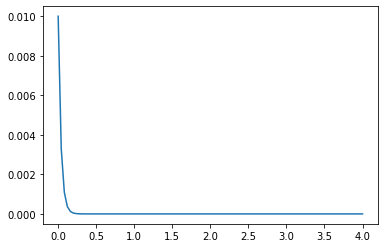

In [30]:
guess = ivp_integrate(weights, [0.01], t)

plt.plot(t, guess.T)
plt.show()

In [23]:
from itertools import product
def make_polynomials(data, max_degree=3, functions={}):
    """Returns the augmented array and the number of transformations"""
    def handle_row(example, nb_variables):
        row = []
        example = np.concatenate([[1], example.reshape(-1)])
        for indexes in combinations_with_replacement(range(nb_variables + 1), max_degree):
            product = np.take(example, indexes).prod()
            row.append(product)
        for name, function in functions.items():
            for var in example[1:].reshape(-1):
                row.append(function(var))
        return row

    if len(data.shape) == 2:
        nb_variables = data.shape[1]
        result = []
        for example in data:
            result.append(handle_row(example, nb_variables))
        return np.array(result, dtype=np.float32), len(result[-1])
    elif len(data.shape) == 1:
        nb_variables = data.shape[0]
        result = handle_row(data, nb_variables)
        return np.array(result, dtype=np.float32), len(result)
    else:
        raise Exception('Shape not understood')
        
def show_weights(weights, 
                 functions={},
                 derivative=False, 
                 variables=None, 
                 max_degree=6, 
                 raw=False, 
                 warn=True, 
                 pde=False):
    if not pde:
        nb_variables = weights.shape[1]
        if not variables:
            variables = ['1', 'x', 'y', 'z']
        variables = variables[:1 + nb_variables]
    else:
        nb_variables = weights.shape[0]
        if not variables:
            variables = ['1', 'u', 'u_x', 'u_{xx}', 'u_{xxx}'][:min(pde + 2, 5)]
    candidate_functions = [reduce(name, variables) for name in combinations_with_replacement(variables, max_degree)]
    candidate_functions += [f'${func}({variable})$' for func, variable in product(functions.keys(), variables[1:])]
    params = [[name] + list(val)
              for name, val in zip(candidate_functions, weights.numpy())]
    headers = ['function'] + ['$\dot{' + str(var) + '}$' if derivative else '$' + str(var) + '_{k+1}$'
                              for var in variables[1:1 + nb_variables]]
    if raw:
        print(tabulate(params, headers=headers, tablefmt="pipe"))
    else:
        display(Markdown(tabulate(params, headers=headers, tablefmt="pipe")))